Scenatio 2:  Forecasting Model (n+1 prediction) for Latency Compensation:

A forecasting model can be designed to predict the force at a future time step ($F_{t + \text{prediction_horizon}}$) based on the current and recent past stress sensor readings (X
t−k
​
 …X
t
​
 ).
The key is to set your prediction_horizon to effectively compensate for the system's latency. If your total latency from sensor reading to controller action is, say, L = 0.5ms, you could train your model to predict the force at time t+L.
When the controller receives this prediction at actual time t+L, it's receiving an estimate of the force at its current actual time, effectively making the feedback real-time despite the system latency. This "predictive feedback" allows the controller to operate more effectively, maintain stability, and achieve better performance.

In [ ]:
import numpy as np
import pandas as pd
import pickle

!pip install tensorflow
!pip install scikeras
!pip install keras_tuner
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout
import tensorflow as tf
from tensorflow.keras import layers
from kerastuner import HyperModel, RandomSearch


from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import tensorflow as tf # Import tensorflow
import keras_tuner as kt
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.5 MB/s eta 0:00:00


<ipython-input-1-544c10f68bc3>:12: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel, RandomSearch


Mounted at /content/drive


In [ ]:
checkpoints_path = '/content/drive/MyDrive/Colab Notebooks/Stress Prediction/checkpoints/'

# Load the splits
with open(f"{checkpoints_path}checkpoint2.pkl", 'rb') as f:
    checkpoints = pickle.load(f)

# Load the feature & target transformers
with open(checkpoints_path + 'power_transformer.pkl','rb') as f:
    pt_dict = pickle.load(f)
pt_X, pt_y = pt_dict['fea'], pt_dict['tar']

# Extract X/y
X_train, y_train = checkpoints['train']['X'], checkpoints['train']['y']
X_val,   y_val   =  checkpoints['val']['X'], checkpoints['val']['y']
X_test,  y_test  =  checkpoints['test']['X'], checkpoints['test']['y']
X_test2pred =  checkpoints['test2predict']['X']



In [ ]:
with open(f'{checkpoints_path}power_transformer.pkl','rb') as f:
    fitted_tf = pickle.load(f)
pt_X = fitted_tf['fea']
pt_Y = fitted_tf['tar']

In [ ]:

def eval_model_raw(model, X, y_true, pt_Y):
    # Predict in transformed space
    y_pred_t = model.predict(X)

    # Ensure y_pred_t is a 2D array
    if y_pred_t.ndim == 1:
        y_pred_t = y_pred_t.reshape(-1, 1)

    # If pt_Y expects feature names, convert to DataFrame with appropriate column names
    if hasattr(pt_Y, 'feature_names_in_'):
        y_pred_t = pd.DataFrame(y_pred_t, columns=pt_Y.feature_names_in_)

    # Inverse-transform back to original scale
    y_pred = pt_Y.inverse_transform(y_pred_t)

    # Ensure y_true is a 2D array
    if y_true.ndim == 1:
        y_true = y_true.reshape(-1, 1)

    # If pt_Y expects feature names, convert y_true to DataFrame
    if hasattr(pt_Y, 'feature_names_in_'):
        y_true = pd.DataFrame(y_true, columns=pt_Y.feature_names_in_)

    y_true_inv = pt_Y.inverse_transform(y_true)

    print("MAE :", mean_absolute_error(y_true_inv, y_pred))
    print("MAPE:", mean_absolute_percentage_error(y_true_inv, y_pred))

    return y_true_inv, y_pred



In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner import HyperModel, RandomSearch
import numpy as np
from tensorflow.keras.layers import Bidirectional


class RNNHyperModel(HyperModel):
    def build(self, hp):
        model = keras.Sequential()

        # RNN type
        rnn_type = hp.Choice("rnn_type", ["LSTM", "GRU"])
        rnn_layer_cls = layers.LSTM if rnn_type == "LSTM" else layers.GRU

        num_rnn_layers = hp.Int("num_rnn_layers", 1, 4)
        rnn_units = hp.Int("rnn_units", 24, 64, step=8)
        return_seq = hp.Choice("return_sequences", [True, False])
        bidirectional = hp.Choice("bidirectional", [True, False])

        for i in range(num_rnn_layers):
            is_last = i == num_rnn_layers - 1
            rs = return_seq if is_last else True
            if i == 0:
                rnn = rnn_layer_cls(rnn_units, return_sequences=rs, input_shape=(20, 18))
            else:
                rnn = rnn_layer_cls(rnn_units, return_sequences=rs)

            if bidirectional:
                model.add(Bidirectional(rnn))
            else:
                model.add(rnn)

        if return_seq:
            model.add(layers.Flatten())

        # Dense layers (same as before)
        dense_initializer = hp.Choice("dense_initializer", ['glorot_uniform', 'he_normal', 'random_normal'])
        dense_activation = hp.Choice("dense_activation", ['linear', 'relu', 'leaky_relu'])
        dense_neurons = hp.Int("dense_units", 24, 64, step=8)
        num_dense_layers = hp.Int("num_dense_layers", 1, 3)
        dense_dropout = hp.Float("dense_dropout", 0.05, 0.5, step=0.05)

        for _ in range(num_dense_layers):
            model.add(layers.Dense(dense_neurons, kernel_initializer=dense_initializer))
            if dense_activation == "leaky_relu":
                model.add(layers.LeakyReLU())
            else:
                model.add(layers.Activation(dense_activation))
            model.add(layers.Dropout(dense_dropout))

        model.add(layers.Dense(3))
        model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])
        return model



# Initialize tuner
tuner = RandomSearch(
    RNNHyperModel(),
    objective="val_loss",
    max_trials=420,
    executions_per_trial=1,
    directory=checkpoints_path,
    project_name="rnn_hp_search1"
)

# Early stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



Reloading Tuner from /content/drive/MyDrive/Colab Notebooks/Stress Prediction/checkpoints/rnn_hp_search1/tuner0.json


Trial 420 Complete [00h 03m 42s]
val_loss: 0.3669115900993347

Best val_loss So Far: 0.19730839133262634
Total elapsed time: 18h 22m 50s

Best DNN Hyperparameters: {'rnn_type': 'LSTM', 'num_rnn_layers': 3, 'rnn_units': 64, 'return_sequences': 1, 'bidirectional': 1, 'dense_initializer': 'he_normal', 'dense_activation': 'leaky_relu', 'dense_units': 56, 'num_dense_layers': 2, 'dense_dropout': 0.35000000000000003}
rnn_type: LSTM
num_rnn_layers: 3
rnn_units: 64
return_sequences: 1
bidirectional: 1
dense_initializer: he_normal
dense_activation: leaky_relu
dense_units: 56
num_dense_layers: 2
dense_dropout: 0.35000000000000003
Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


328/328 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - loss: 0.2959 - mae: 0.3923 - mape: 1678.5134 - val_loss: 1.4715 - val_mae: 0.9853 - val_mape: 907.8232
Epoch 2/25
328/328 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.1222 - mae: 0.2575 - mape: 1286.5718 - val_loss: 0.8675 - val_mae: 0.7688 - val_mape: 635.3309
Epoch 3/25
328/328 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.1044 - mae: 0.2377 - mape: 1206.0175 - val_loss: 0.9488 - val_mae: 0.7709 - val_mape: 609.3783
Epoch 4/25
328/328 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0978 - mae: 0.2288 - mape: 988.7030 - val_loss: 0.8882 - val_mae: 0.7767 - val_mape: 692.2544
Epoch 5/25
328/328 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.0950 - mae: 0.2262 - mape: 1013.9684 - val_loss: 0.8479 - val_mae: 0.7469 - val_mape: 650.1396
Epoch 6/25
328/328 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0874 - mae: 0.2164 - mape: 959.7561 - val_loss: 0.6736 - val_mae: 0.7047 - val_mape: 579.3015
Epoch 7/25
328/328 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - los

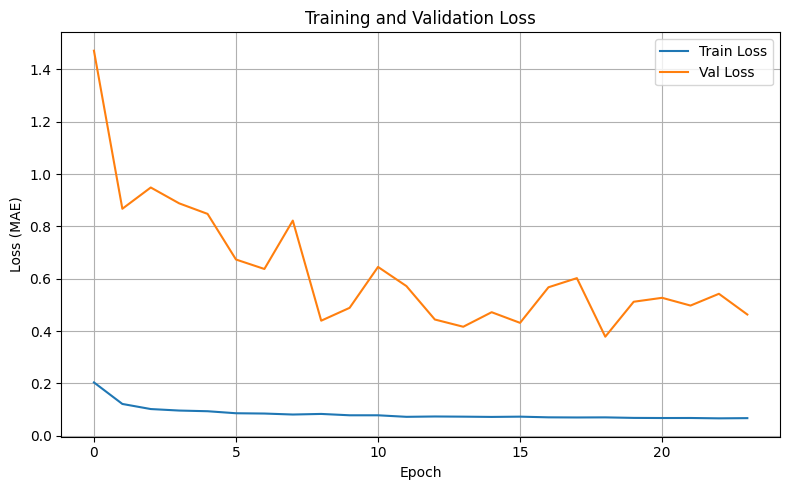

In [ ]:
# Search
tuner.search(X_train, y_train,
             validation_data=(X_val, y_val),
             epochs=25,
             batch_size=20,
             callbacks=[early_stop])


# Get best model
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"\nBest DNN Hyperparameters: {best_hps.values}")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")


# Rebuild model with best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Fit the best model
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=32,
    callbacks= [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

# Save the best model
best_model.save(f'{checkpoints_path}best_rnn_model.keras')
print(f"Best LSTM model saved to {checkpoints_path}best_rnn_model.keras")

# Plot training & validation loss values
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print("=== RNN on Test ===-Evaluation based on Original Scale")
y_true, y_pred = eval_model_raw(best_model, X_test, y_test, pt_Y)

=== RNN on Test ===-Evaluation based on Original Scale
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
MAE : 0.3089360026561316
MAPE: 3.543419075312882


Plot =)

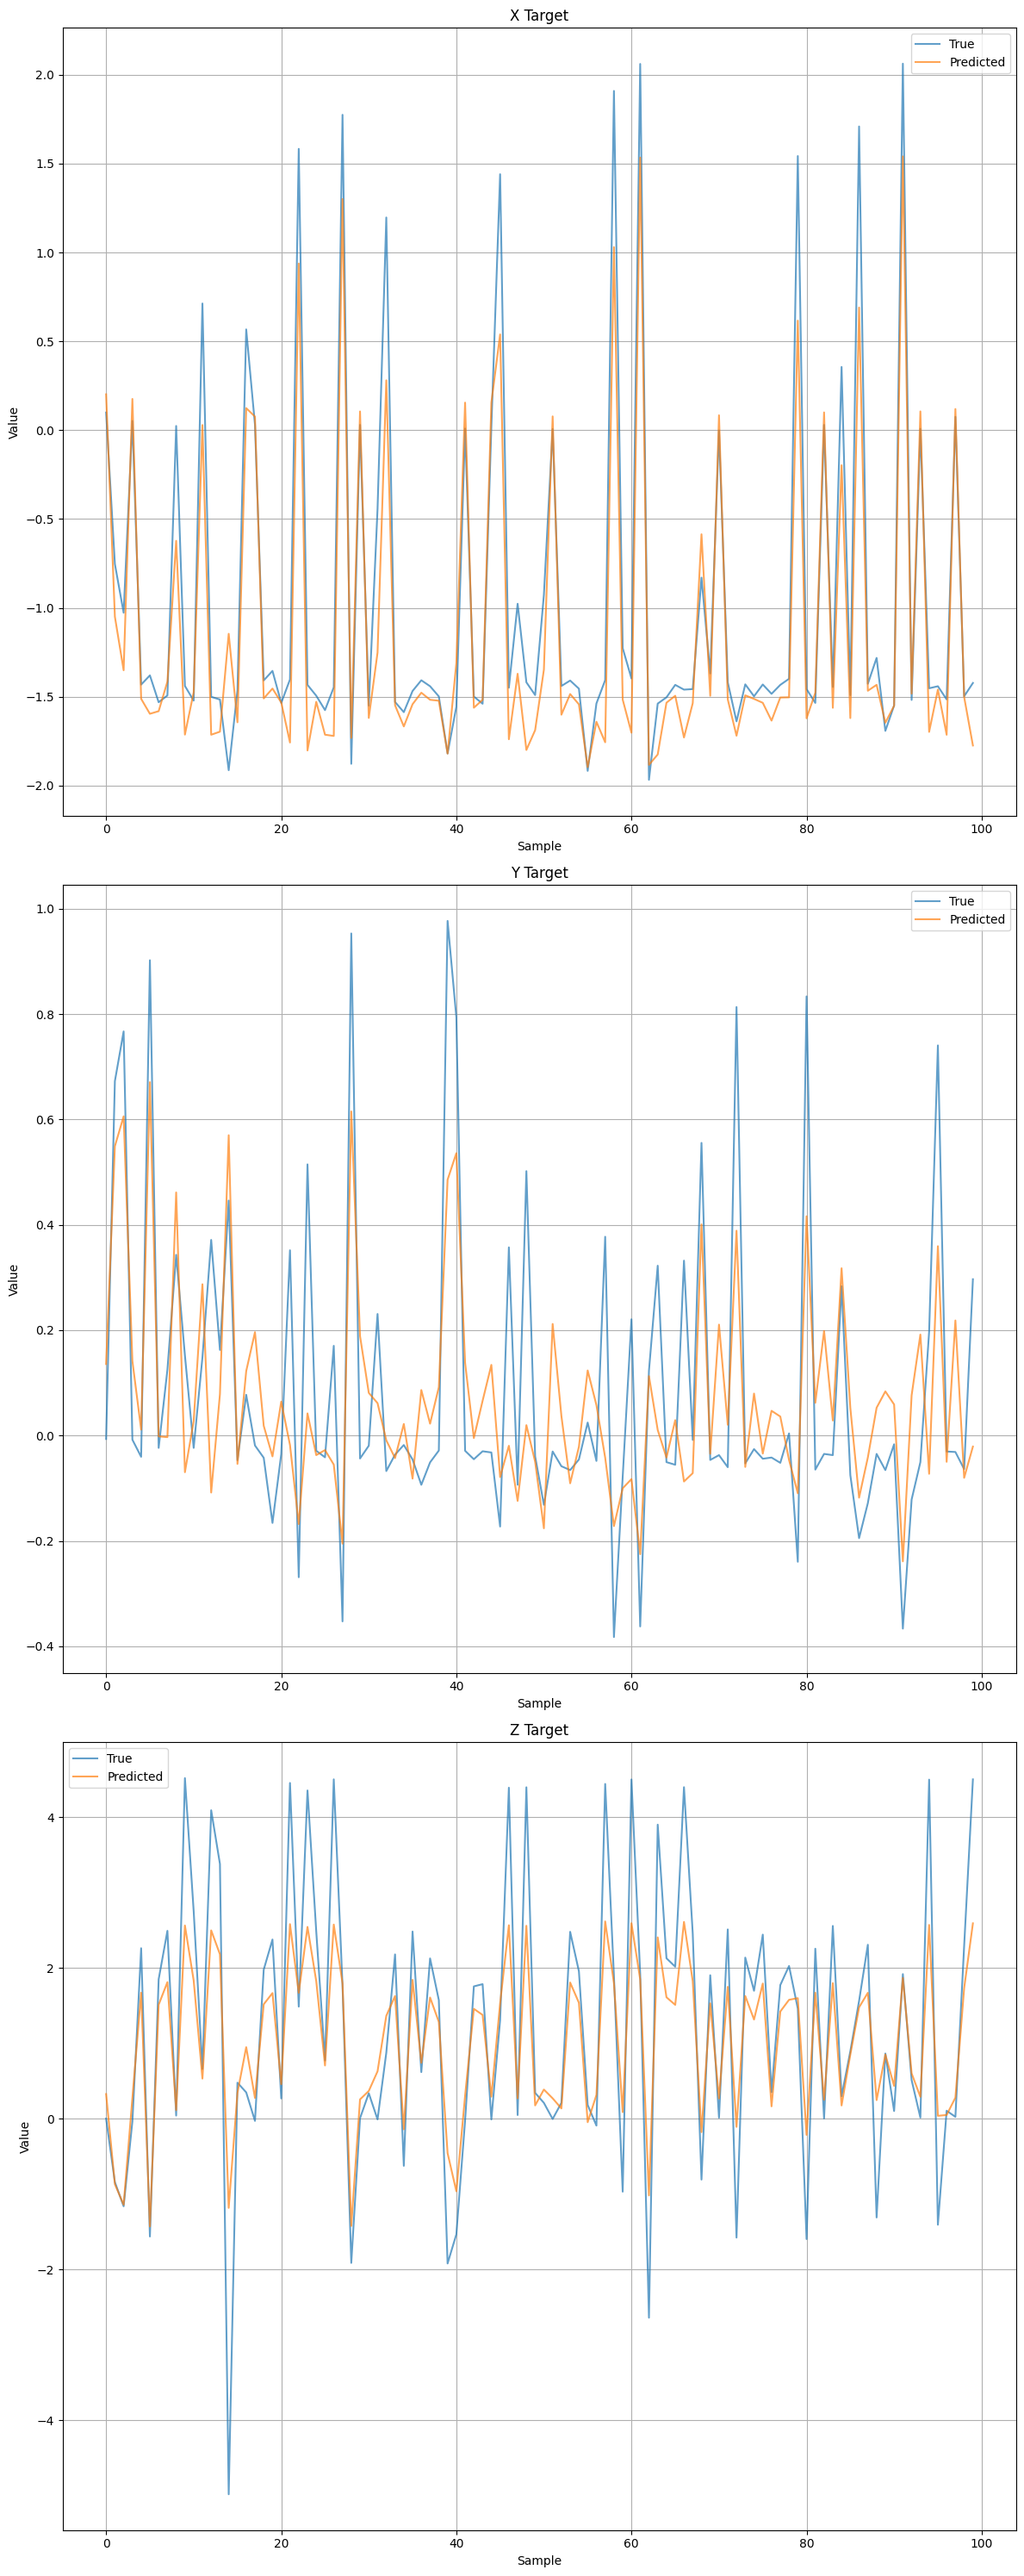

In [ ]:
# Convert to numpy arrays if needed
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Random sampling (e.g., 500 points)
np.random.seed(42)
sample_size = 100
sample_indices = np.random.choice(len(y_true), size=min(sample_size, len(y_true)), replace=False)

y_true_sampled = y_true[sample_indices]
y_pred_sampled = y_pred[sample_indices]

target_names = ['X', 'Y', 'Z']

plt.figure(figsize=(12, 30))

for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(y_true_sampled[:, i], label='True', alpha=0.7)
    plt.plot(y_pred_sampled[:, i], label='Predicted', alpha=0.7)
    plt.title(f'{target_names[i]} Target')
    plt.xlabel('Sample')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
def inv_transform_preds(y_pred_t, pt_y):
    # Directly inverse-transform the full array:
    return pt_y.inverse_transform(y_pred_t)


y_sub_t = best_model.predict(X_test2pred)
y_sub   = inv_transform_preds(pd.DataFrame(y_sub_t, columns=['Z (kN)', 'Y (kN)', 'X (kN)']), pt_Y)

# Convert y_pred to a DataFrame
y_sub = pd.DataFrame(y_sub, columns=['Z (kN)', 'Y (kN)', 'X (kN)'])



3914/3914 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step


In [ ]:
#Backfill is done since the top 20 row of feature were used as part of the temporal feature in batch 1. Hence the closest value will be the 21th value.

# Load the splits
with open(f"{checkpoints_path}checkpoint.pkl", 'rb') as f:
    checkpoints = pickle.load(f)
X_test2pred_1 =  checkpoints['test2predict']['X']

print(X_test2pred_1.shape)
print(y_sub.shape)

# Reindex y_sub to match X_test2predict's index length
# Add 20 NaN rows at the beginning
pad = pd.DataFrame(np.nan, index=range(20), columns=y_sub.columns).astype(y_sub.dtypes.to_dict())
y_sub_padded = pd.concat([pad, y_sub], ignore_index=True)

# Ensure same length as X_test2predict
y_sub_padded = y_sub_padded.iloc[:len(X_test2pred_1)].copy()

# Backward fill to push predictions up to top 20 rows
y_sub_bfill = y_sub_padded.bfill()

# Merge with X_test2predict (must be same length)
X_test2predict_reset = X_test2pred_1.reset_index(drop=True)
submission_df = pd.concat([X_test2predict_reset, y_sub_bfill], axis=1)
print(submission_df.shape)
print(submission_df.head(2))


submission_df.to_excel(f'{checkpoints_path}submission_best(Scenario2).xlsx', index=False)


(125243, 18)
(125223, 3)
(125243, 21)
       1_red    1_blue  1_yellow      2_red     2_blue   2_yellow      3_red  \
0 -12.057262 -4.761482 -8.601844  87.792969 -32.508892 -32.194313 -35.198792   
1  -4.739696 -3.143384 -8.263125  88.090309 -27.136887 -32.596123 -36.028408   

      3_blue   3_yellow      4_red  ...   4_yellow      5_red     5_blue  \
0 -32.017544 -31.783356 -38.175938  ... -16.594654 -25.173454 -31.440985   
1 -33.828205 -32.184719 -38.733276  ... -19.157318 -25.798365 -32.846844   

    5_yellow      6_red     6_blue  6_yellow    Z (kN)    Y (kN)    X (kN)  
0 -26.871092 -37.771828 -17.144352 -5.418063 -1.431897  0.336998  1.411371  
1 -26.628025 -37.553535 -15.890195 -6.920620 -1.431897  0.336998  1.411371  

[2 rows x 21 columns]
